In [1]:
!uv add numpy matplotlib scipy pandas

Resolved 107 packages in 15ms
Audited 104 packages in 17ms



=== РЕЗУЛЬТАТЫ ДЛЯ 2 НУКЛИДОВ ===
 Нуклид    A₀ (имп/с)                     λ (с⁻¹)       T₁/₂ (ч)         N₀ (отн. ед.)
      1  99.92 ± 0.46 4.337584e-05 ± 1.284538e-07  4.439 ± 0.013 2.303e+06 ± 1.256e+04
      2 200.08 ± 0.46 2.891079e-06 ± 3.515026e-08 66.598 ± 0.810 6.921e+07 ± 8.563e+05


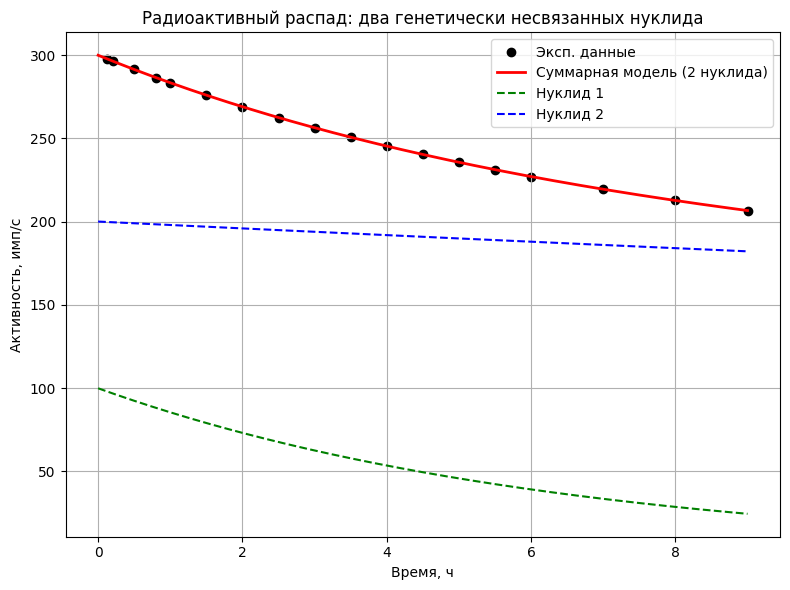

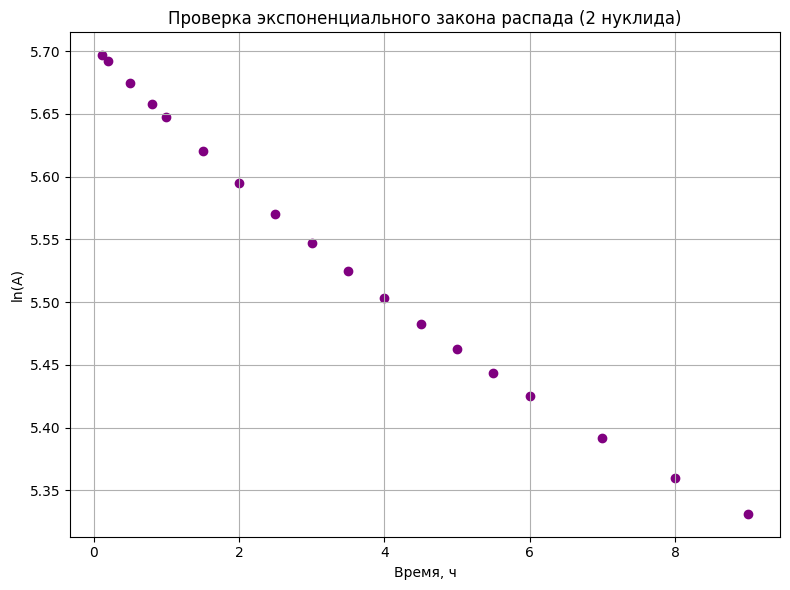

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === ДАННЫЕ ===
data = {
    "t_h": [0.12, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 7, 8, 9],
    "N": [18774, 18691, 18387, 18096, 17909, 17462, 17045, 16654, 16289, 15946, 
          15626, 15325, 15042, 14777, 14527, 14071, 13665, 13302]
}

background_rate = 15  # фон, имп/с
dt = 60               # с

# === ПОДГОТОВКА ДАННЫХ ===
df = pd.DataFrame(data)
df["t_s"] = df["t_h"] * 3600
df["A_meas"] = df["N"] / dt
df["A_corr"] = df["A_meas"] - background_rate

# === МОДЕЛЬ ДЛЯ 2 НУКЛИДОВ ===
def decay_2(t, A1, l1, A2, l2):
    return A1 * np.exp(-l1 * t) + A2 * np.exp(-l2 * t)

# === АППРОКСИМАЦИЯ ===
p0 = [200, 1e-5, 50, 5e-6]  # начальные приближения
popt, pcov = curve_fit(decay_2, df["t_s"], df["A_corr"], p0=p0, maxfev=20000)

params = popt
errs = np.sqrt(np.diag(pcov))

# === РАСЧЁТ ПАРАМЕТРОВ ===
results_table = []
for i in range(2):
    A = params[2*i]
    lam = params[2*i + 1]
    dA = errs[2*i]
    dlam = errs[2*i + 1]
    T_half = np.log(2) / lam
    dT_half = T_half * (dlam / lam)
    N0 = A / lam
    dN0 = N0 * np.sqrt((dA/A)**2 + (dlam/lam)**2)
    results_table.append({
        "Нуклид": i+1,
        "A₀ (имп/с)": f"{A:.2f} ± {dA:.2f}",
        "λ (с⁻¹)": f"{lam:.6e} ± {dlam:.6e}",
        "T₁/₂ (ч)": f"{T_half/3600:.3f} ± {dT_half/3600:.3f}",
        "N₀ (отн. ед.)": f"{N0:.3e} ± {dN0:.3e}"
    })

# === ВЫВОД РЕЗУЛЬТАТОВ ===
print("\n=== РЕЗУЛЬТАТЫ ДЛЯ 2 НУКЛИДОВ ===")
df_res = pd.DataFrame(results_table)
print(df_res.to_string(index=False))

# === ГРАФИКИ ===
t_fit = np.linspace(0, df["t_s"].max(), 500)
A_fit = decay_2(t_fit, *params)
colors = ["g", "b"]

plt.figure(figsize=(8,6))
plt.scatter(df["t_s"]/3600, df["A_corr"], color="black", label="Эксп. данные")
plt.plot(t_fit/3600, A_fit, 'r-', lw=2, label="Суммарная модель (2 нуклида)")

# Отдельные вклады
for i in range(2):
    Ai, li = params[2*i], params[2*i + 1]
    plt.plot(t_fit/3600, Ai*np.exp(-li*t_fit), "--", color=colors[i], label=f"Нуклид {i+1}")

plt.xlabel("Время, ч")
plt.ylabel("Активность, имп/с")
plt.title("Радиоактивный распад: два генетически несвязанных нуклида")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === ГРАФИК ln(A) ===
plt.figure(figsize=(8,6))
plt.scatter(df["t_s"]/3600, np.log(df["A_corr"]), color="purple")
plt.xlabel("Время, ч")
plt.ylabel("ln(A)")
plt.title("Проверка экспоненциального закона распада (2 нуклида)")
plt.grid(True)
plt.tight_layout()
plt.show()

# По значениям периодов полураспада они могут быть отождествлены как изотопы йода-132 (первый нуклид, короткоживущий) и теллура-132 (второй нуклид, долгоживущий) — типичные продукты деления урана.